# Импорт библиотек

Импорты и функции вынесены в отдельный файл

In [1]:
import sys
sys.path.append('../')

In [2]:
from src.utils import *

In [3]:
from preprocessing import get_preprocessed_data

# Обучение моделей 

Будем логировать эксперимент в mlflow

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

# Установите путь к директории артефактов
mlflow.set_tracking_uri(os.getenv('MLFLOW_TRACKING_URI'))
mlflow.set_experiment("Laser_cutting_decision_tree")

<Experiment: artifact_location='file:///home/mikhail/projects/laser_cutting/artifacts/mlruns/330267768111100363', creation_time=1726396263969, experiment_id='330267768111100363', last_update_time=1726396263969, lifecycle_stage='active', name='Laser_cutting_decision_tree', tags={}>

In [5]:
data = get_preprocessed_data()

/home/mikhail/projects/laser_cutting/notebooks/preprocessing.py:73: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['operation_num'] = data['Operation'].replace(mapping)


Отберем признаки для обучения решающего дерева

In [6]:
tree_features = ['Width', 'Length', 'Cut_length', 'Cut_quantity',
                 'keywords_count', 'Thickness', 'avg_group_speed', 'density',
                 'L/W', 'operation_num']

## Разделим на выборки

In [7]:
X = data[tree_features]
y = data['Time']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

Создадим датасет для сравнения, добавим baseline

## Baseline

Для baseline просто считаем по формуле

In [8]:
with mlflow.start_run(run_name="Baseline"):
    # Логируем параметры модели
    mlflow.log_param("model_type", "Baseline")
    
    start_time = datetime.now()
    compare = X_test.copy()
    compare['base_y_pred'] = compare['Cut_length'] / compare['avg_group_speed']
    compare = compare.join(y_test)
    end_time = datetime.now()
    
    mlflow.log_metric("training_time", (end_time - start_time).total_seconds())
       
    # Вычисляем метрики  
    actual_values = compare['Time']
    predicted_values = compare['base_y_pred']
    base_metrics=get_and_print_metrics(predicted_values, actual_values)
    
    
#     # Логируем метрики
    for key, value in base_metrics.items():
        mlflow.log_metric(key, value)
    
    # Сохраняем модель
    mlflow.log_param("baselie", "base_y_pred = Cut_length / avg_group_speed")

RMSE: 36.781007935438474
MAPE: 50.47%
SMAPE: 39.48%
R2: 0.26
Процент значений с ошибкой не более 20%: 42.82%
WAPE: 42.06%


In [9]:
compare[['base_y_pred', 'Time']].head(3)

,base_y_pred,Time
372616,17.621,16.000
134729,15.784,24.000
199720,16.558,18.000


На глаз, для первых 3 значений, предсказаниче получилось приемлемым

## Решающее дерево

Подберем гиперпараметры модели

In [10]:
param_grid = {
    'max_depth': [None, 2, 5 ,10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 10],
    'max_features': ['sqrt', 'log2'],
}


search_tree = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                           param_grid=param_grid)
search_tree.fit(X_val,y_val)
print(search_tree.best_params_)

{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2}


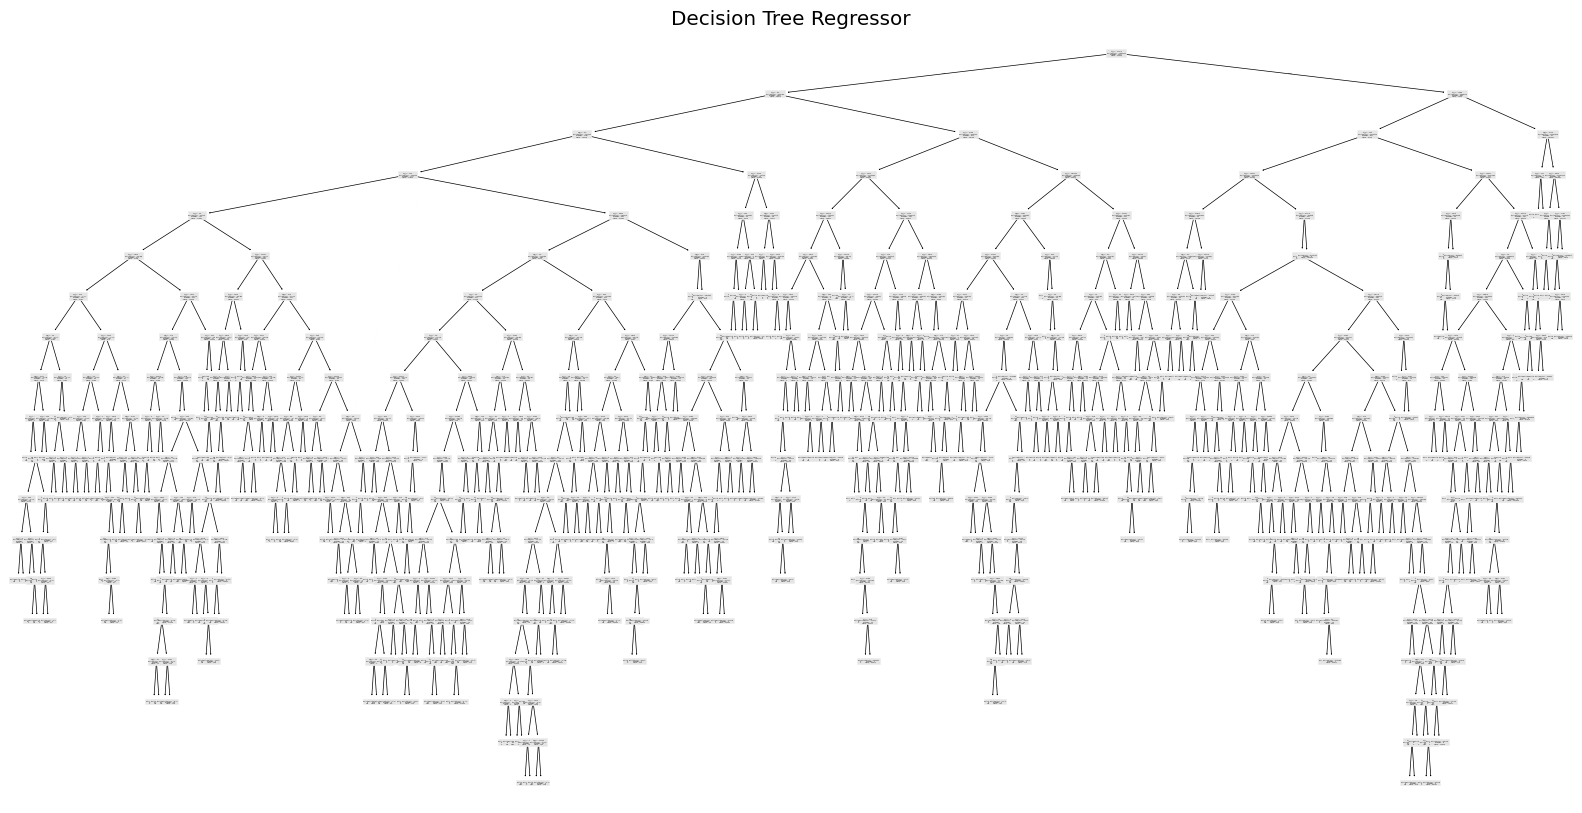

In [11]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(search_tree.best_estimator_)
plt.title('Decision Tree Regressor')
plt.show()

In [12]:
with mlflow.start_run(run_name="DecisionTree"):
    mlflow.log_param("model_type", "DecisionTree")
        
    start_time = datetime.now()
    cutting_tree = DecisionTreeRegressor(random_state=42, 
                                         **search_tree.best_params_)
    cutting_tree.fit(X_train,y_train)
    cutting_tree_predict = cutting_tree.predict(X_test)
    compare['y_cutting_tree_predict'] = cutting_tree_predict
    end_time = datetime.now()
        
    mlflow.log_metric("training_time", (end_time - start_time).total_seconds())
        
    cutting_tree_metrics = get_and_print_metrics(cutting_tree_predict, y_test)     
    
    for key, value in cutting_tree_metrics.items():
        mlflow.log_metric(key, value)
    
    # Сохраняем модель
    mlflow.sklearn.log_model(cutting_tree, "cutting_tree_model")

RMSE: 22.65489413281528
MAPE: 27.29%
SMAPE: 21.56%
R2: 0.72
Процент значений с ошибкой не более 20%: 62.11%
WAPE: 24.30%


2024/10/05 15:35:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Сравнение с baseline

In [13]:
base_metrics['model_name'] = 'base'
cutting_tree_metrics['model_name'] = 'decision_tree'

metrics_dicts = [
    base_metrics,
    cutting_tree_metrics,
]

# Создаем DataFrame из списка словарей
compare_metrics = pd.DataFrame(metrics_dicts)

# Переименуем столбец 'model_name' в индекс DataFrame
compare_metrics.set_index('model_name', inplace=True)

compare_metrics

,rmse,mape,smape,R2,percentage_within_20,wape
model_name,,,,,,
base,36.781,0.505,39.483,0.263,42.825,42.055
decision_tree,22.655,0.273,21.565,0.720,62.109,24.299


Для сравнения, посмотрим на графике, как распределены ошибки (в процентах)

In [14]:
def get_percent_error(pred, fact):
    error = abs(fact - pred)
    return error / fact * 100

In [15]:
compare['base_percent_error'] = compare.apply(lambda x: get_percent_error(x['base_y_pred'], x['Time']), axis=1)
compare['tree_percent_error'] = compare.apply(lambda x: get_percent_error(x['y_cutting_tree_predict'], x['Time']), axis=1)

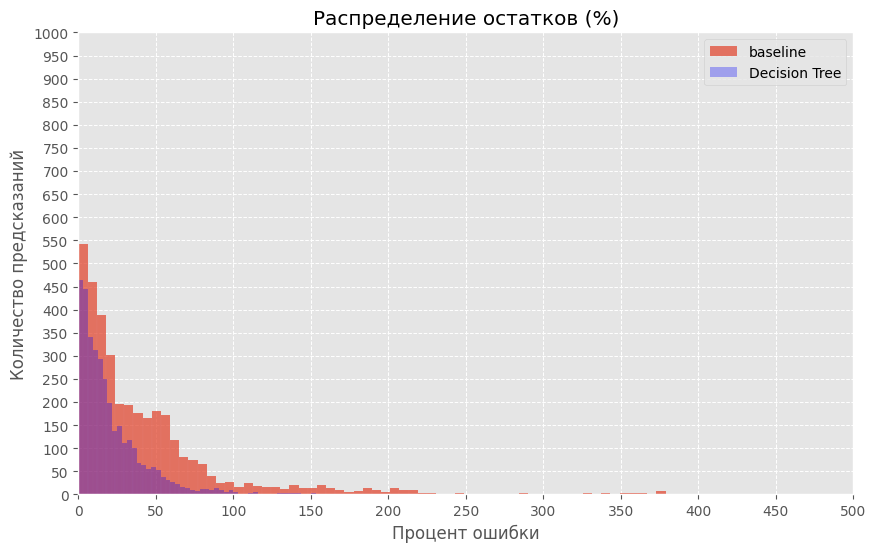

In [16]:
# Построение гистограммы с помощью Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(compare, x='base_percent_error', label = 'baseline')
sns.histplot(compare, x='tree_percent_error', color='blue', alpha=0.3, label='Decision Tree')

# Ограничиваем значения по оси X до 1000
plt.xlim(0,500)

# Задаем шаг для меток оси X (например, шаг 100)
step = 50
plt.xticks(np.arange(0, 501, step))
plt.yticks(np.arange(0, 1001, step))

# Включаем сетку и задаем тот же шаг
plt.grid(True, axis='x', which='both', linestyle='--', linewidth=0.7)
plt.grid(True, axis='y', which='both', linestyle='--', linewidth=0.7)


# Добавим подписи и заголовок (если нужно)
plt.xlabel('Процент ошибки')
plt.ylabel('Количество предсказаний')
plt.title('Распределение остатков (%)')

plt.legend()

plt.show()

## Случайный лес

In [17]:
from scipy.stats import randint
from sklearn.utils import resample

In [18]:
# Выбираем случайную подвыборку из 10% данных для поиска гиперпараметров
#X_subset, y_subset = resample(X_val, y_val, replace=False, n_samples=int(len(X)*0.1))

param_distributions = {
    'n_estimators': randint(50, 100), 
    'max_depth': list(range(10, 30)), 
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt']
}

# Создание модели и RandomizedSearchCV
forest_model = RandomForestRegressor(random_state=42)
forest_search = RandomizedSearchCV(estimator=forest_model, param_distributions=param_distributions,
                                   random_state=42, n_iter=5, cv=3, n_jobs=-1)

# Запуск поиска лучших параметров на подмножестве данных
forest_search.fit(X_val, y_val)

# Вывод лучших параметров и лучшей оценки
print("Лучшие параметры:", forest_search.best_params_)

Лучшие параметры: {'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 71}


In [19]:
with mlflow.start_run(run_name="RandomForest"):
    mlflow.log_param("model_type", "RandomForest")
        
    start_time = datetime.now()
    forest = RandomForestRegressor(random_state=42, 
                                         **forest_search.best_params_)
    forest.fit(X_train,y_train)
    forest_predict = forest.predict(X_test)
    compare['y_forest_predict'] = forest_predict
    end_time = datetime.now()
        
    mlflow.log_metric("training_time", (end_time - start_time).total_seconds())
        
    forest_metrics = get_and_print_metrics(forest_predict, y_test)     
    
    for key, value in forest_metrics.items():
        mlflow.log_metric(key, value)
    
    # Сохраняем модель
    mlflow.sklearn.log_model(cutting_tree, "cutting_forest_model")

RMSE: 17.804306313526073
MAPE: 22.77%
SMAPE: 18.43%
R2: 0.83
Процент значений с ошибкой не более 20%: 64.82%
WAPE: 19.28%


2024/10/05 15:35:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


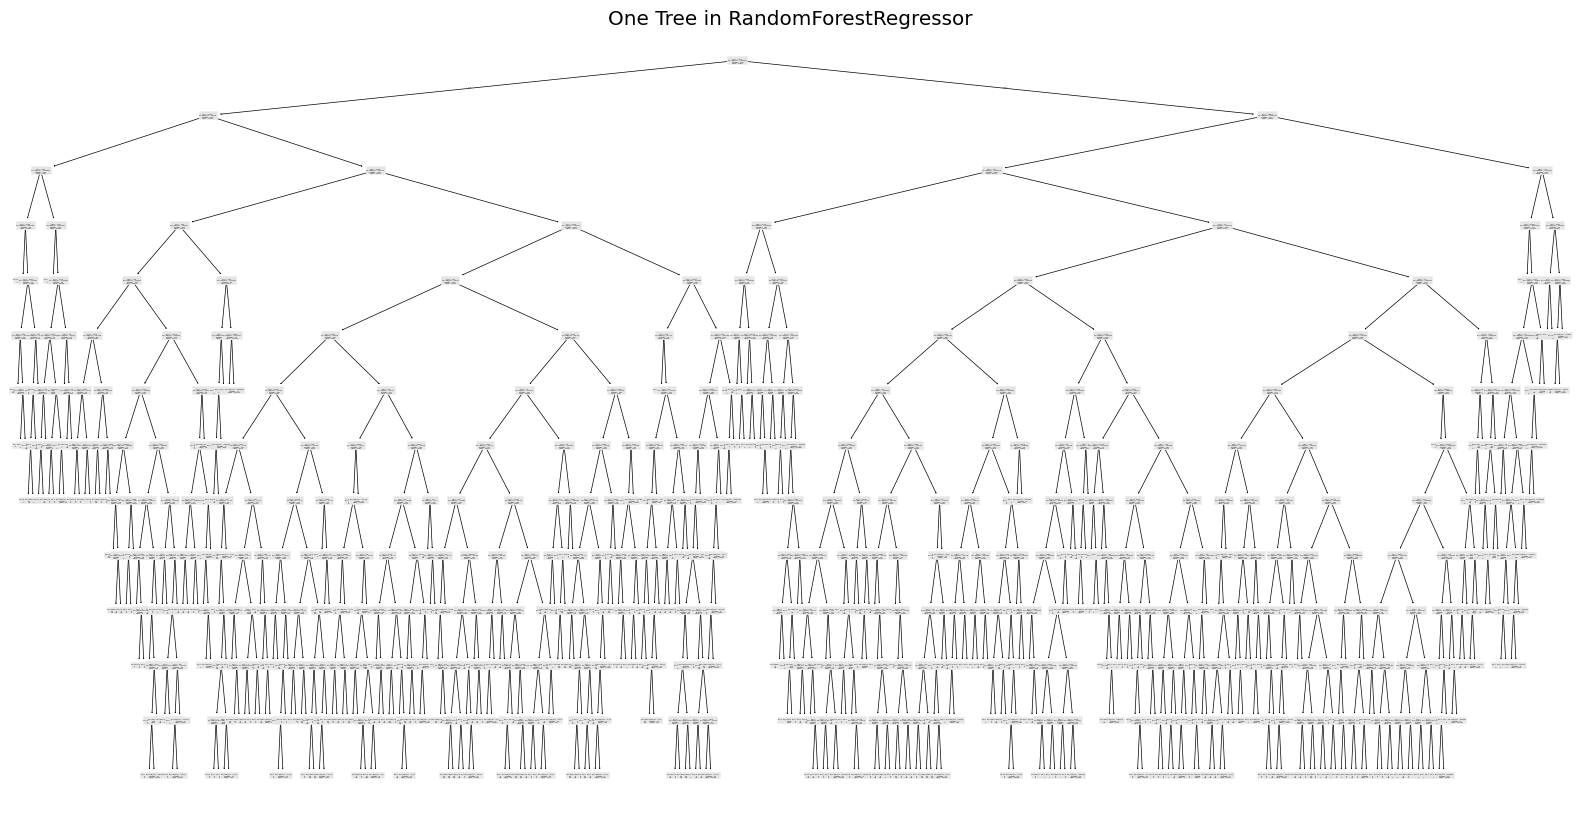

In [20]:
# Визуализация одного из деревьев в случайном лесе
plt.figure(figsize=(20, 10))
plot_tree(forest.estimators_[0])
plt.title('One Tree in RandomForestRegressor')
plt.show()

In [21]:
compare['base_percent_error'] = compare.apply(lambda x: get_percent_error(x['base_y_pred'], x['Time']), axis=1)
compare['forest_percent_error'] = compare.apply(lambda x: get_percent_error(x['y_forest_predict'], x['Time']), axis=1)

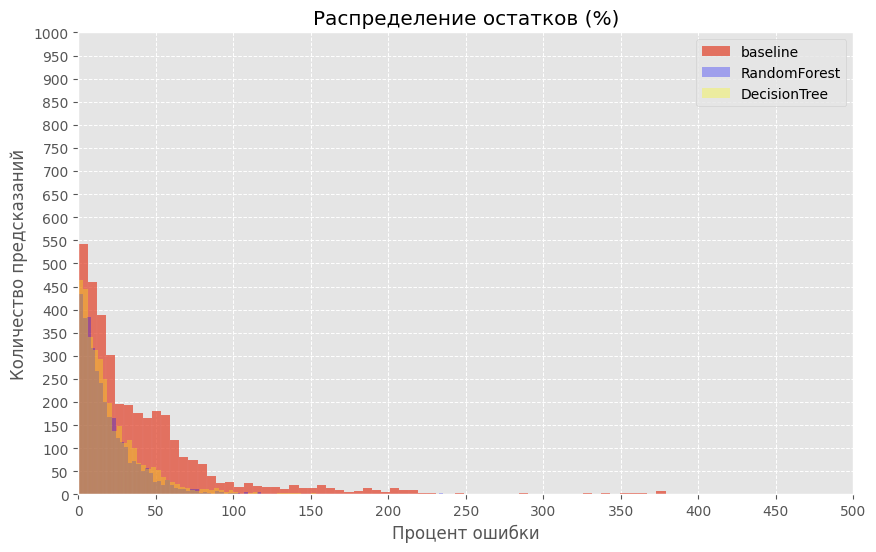

In [22]:
# Построение гистограммы с помощью Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(compare, x='base_percent_error', label='baseline')
sns.histplot(compare, x='forest_percent_error', color='blue', alpha=0.3, label='RandomForest')
sns.histplot(compare, x='tree_percent_error', color='yellow', alpha=0.3, label='DecisionTree')


# Ограничиваем значения по оси X до 1000
plt.xlim(0,500)

# Задаем шаг для меток оси X (например, шаг 100)
step = 50
plt.xticks(np.arange(0, 501, step))
plt.yticks(np.arange(0, 1001, step))

# Включаем сетку и задаем тот же шаг
plt.grid(True, axis='x', which='both', linestyle='--', linewidth=0.7)
plt.grid(True, axis='y', which='both', linestyle='--', linewidth=0.7)


# Добавим подписи и заголовок (если нужно)
plt.xlabel('Процент ошибки')
plt.ylabel('Количество предсказаний')
plt.title('Распределение остатков (%)')

plt.legend()

plt.show()

In [23]:
df_forest_metrics = pd.DataFrame(forest_metrics, index=['RandomForest'])
compare_metrics = pd.concat([compare_metrics, df_forest_metrics], axis=0)
compare_metrics

,rmse,mape,smape,R2,percentage_within_20,wape
base,36.781,0.505,39.483,0.263,42.825,42.055
decision_tree,22.655,0.273,21.565,0.720,62.109,24.299
RandomForest,17.804,0.228,18.434,0.827,64.815,19.279


Лучшие результаты показывает случайный лес